# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [109]:
# import libraries
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import nltk
import pickle
import re

import matplotlib.pyplot as plt

nltk.download('punkt')
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

np.random.seed(42)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hjone\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hjone\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Functions

In [110]:
def get_eval_metrics(actual, predicted, col_names):
    """
    Calculate evaluation metrics for model
    
    Args:
    actual: array. Array containing actual labels.
    predicted: array. Array containing predicted labels.
    col_names: List of strings. List containing names for each of the predicted fields.
       
    Returns:
    metrics_df: dataframe. Dataframe containing the accuracy, precision, recall 
    and f1 score for a given set of actual and predicted labels.
    """
    metrics = []
    
    # average{‘micro’, ‘macro’, ‘samples’,’weighted’, ‘binary’} or None, default=’binary’
    avg_type='weighted'  # weighted is supposed to take label imbalance into account 
    zero_division_treatment=0 # 0,1,'warn'
    
    # Calculate evaluation metrics for each set of labels
    for i in range(len(col_names)):
        accuracy = accuracy_score(actual[:, i], predicted[:, i])
        precision = precision_score(actual[:, i], predicted[:, i], average=avg_type, zero_division=zero_division_treatment)
        recall = recall_score(actual[:, i], predicted[:, i], average=avg_type, zero_division=zero_division_treatment)
        f1 = f1_score(actual[:, i], predicted[:, i], average=avg_type, zero_division=zero_division_treatment)
        
        metrics.append( [accuracy, precision, recall, f1] )
    
    # Create dataframe containing metrics
    metrics = np.array(metrics)
    metrics_df = pd.DataFrame(data = metrics, index = col_names, columns = ['Accuracy', 'Precision', 'Recall', 'F1'])
      
    return metrics_df


# Define performance metric for use in grid search scoring object
def performance_metric(y_true, y_pred)->float:
    """
    
    Calculate median F1 score for all of the output classifiers
    
    Args:
    y_true: array. Array containing actual labels.
    y_pred: array. Array containing predicted labels.
        
    Returns:
    score: float. Median F1 score for all of the output classifiers
    """
    average_type='binary'
    f1_list = []
    for i in range(np.shape(y_pred)[1]):
        f1 = f1_score(np.array(y_true)[:, i], y_pred[:, i],average='micro')
        f1_list.append(f1)
        
    score = np.median(f1_list)
    return score

In [111]:
tableName='Message_Categories'
dbName='Disaster_Response_Message.db'

In [112]:
# load data from database
engine = create_engine('sqlite:///' + dbName)
df = pd.read_sql_table(table_name=tableName, con=engine)

feature_list=['id', 'message', 'original', 'genre']
X = df['message']
Y = df.drop(feature_list, axis=1)

In [113]:
print(type(X))

<class 'pandas.core.series.Series'>


In [114]:
print("X",X.shape)
print("Y",Y.shape)

X (26177,)
Y (26177, 36)


(26177, 36)


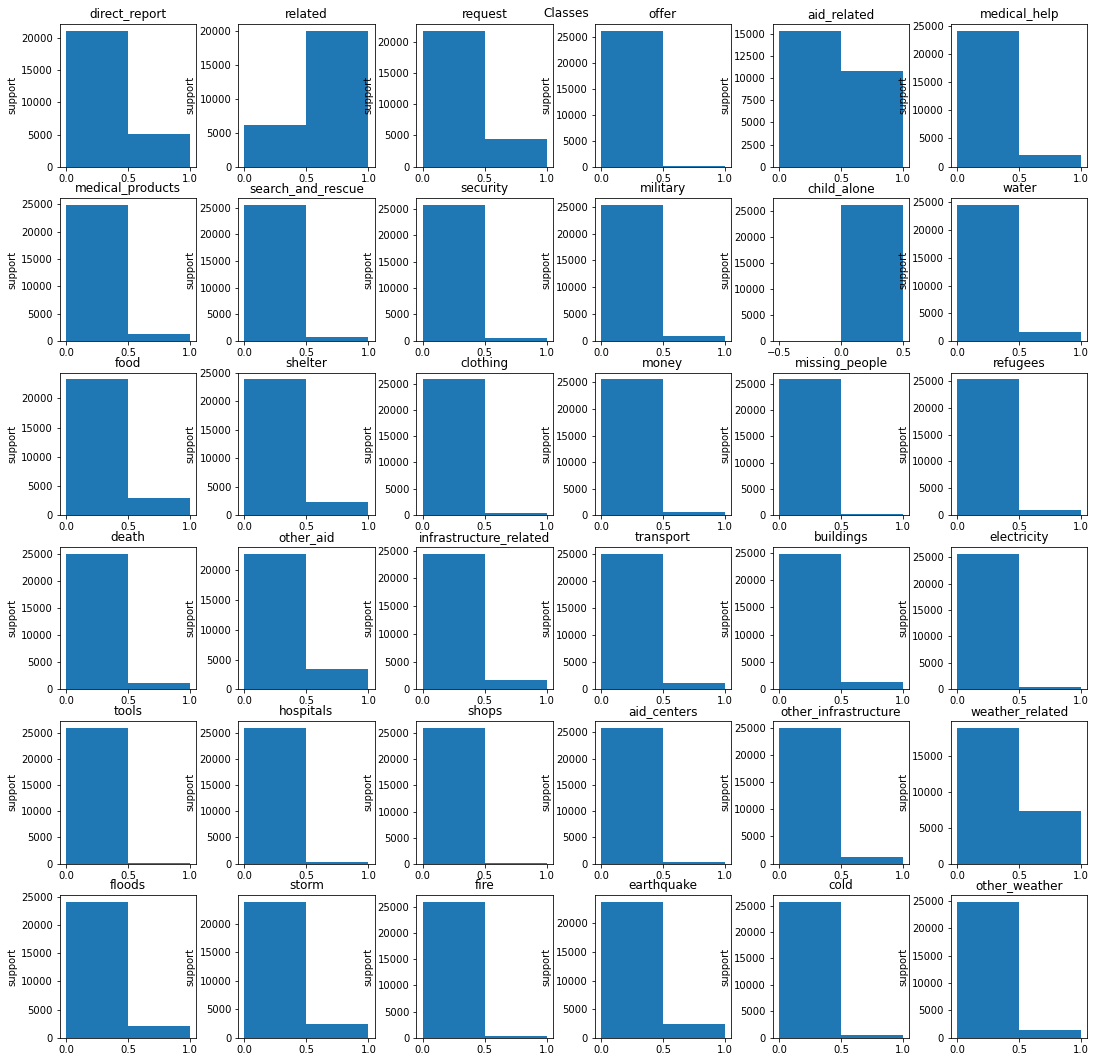

In [115]:
# Visualize target class labels support

print (Y.shape)

fig, axs = plt.subplots(6,6,figsize=(15,15))

axs = np.array(axs)

fig.suptitle("Classes")
    
fig.tight_layout()    


    
for i, ax in enumerate(fig.axes):
    ax.hist(Y[Y.columns[i-1]],bins=2)
    ax.set_title(Y.columns[i-1])
    ax.set_ylabel('support')
    ax.set_xlabel('')

Nearly all classes are unbalanced

### 2. Write a tokenization function to process your text data

In [116]:
def tokenize(text):
    """
    Tokenize the text message fields
    
    Args:
    text (string) text to tokenize
    
    Returns:
    List tokenised text
    """
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
    
    tokens = word_tokenize(text)
    

    
    stop_words = stopwords.words("english")
    
    #tokenised = [stemmer.stem(word) for word in tokens if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    # Lemmatize
    tokenised = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
                 
    return tokenised

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

CountVectorizer : Builds a count dictionary with count for each word
TfidTransformer : TF-FTI Term Frequency times inverse document frequency. Reduces weightage of common words


In [117]:
pipeline = Pipeline ( [
    ('vect', CountVectorizer(tokenizer = tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(RandomForestClassifier()))
    ] )

In [118]:
# List all the parameters for this pipeline
#pipeline.get_params()

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [119]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,test_size=0.2, random_state = 42)

print(X_train.shape)
print(Y_train.shape)

(20941,)
(20941, 36)


In [120]:
# Train pipeline model
model1=pipeline.fit(X_train, Y_train)

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [121]:
# Calculate evaluation metrics for training set
Y_train_pred = pipeline.predict(X_train)
col_names = list(Y.columns.values)

In [122]:
eval_metrics0 = get_eval_metrics(np.array(Y_train), Y_train_pred, col_names)
print(eval_metrics0)

                        Accuracy  Precision    Recall        F1
related                 0.998520   0.998521  0.998520  0.998520
request                 0.999236   0.999236  0.999236  0.999236
offer                   1.000000   1.000000  1.000000  1.000000
aid_related             0.998997   0.998997  0.998997  0.998997
medical_help            0.999713   0.999714  0.999713  0.999713
medical_products        0.999713   0.999714  0.999713  0.999713
search_and_rescue       0.999857   0.999857  0.999857  0.999857
security                0.999761   0.999761  0.999761  0.999760
military                0.999952   0.999952  0.999952  0.999952
child_alone             1.000000   1.000000  1.000000  1.000000
water                   1.000000   1.000000  1.000000  1.000000
food                    0.999952   0.999952  0.999952  0.999952
shelter                 0.999904   0.999905  0.999904  0.999904
clothing                0.999952   0.999952  0.999952  0.999952
money                   1.000000   1.000

In [123]:
eval_metrics0.describe()

,Accuracy,Precision,Recall,F1
count,36.000000,36.000000,36.000000,36.000000
mean,0.999764,0.999764,0.999764,0.999764
std,0.000339,0.000339,0.000339,0.000339
min,0.998520,0.998521,0.998520,0.998520
25%,0.999713,0.999714,0.999713,0.999713
50%,0.999904,0.999905,0.999904,0.999904
75%,0.999952,0.999952,0.999952,0.999952
max,1.000000,1.000000,1.000000,1.000000


In [124]:
# Calculate predicted classes for test dataset
Y_test_pred = pipeline.predict(X_test)

In [125]:
# Calculate evaluation metrics
eval_metrics1 = get_eval_metrics(np.array(Y_test), Y_test_pred, col_names)
print(eval_metrics1)

                        Accuracy  Precision    Recall        F1
related                 0.825439   0.814674  0.825439  0.806826
request                 0.888083   0.883239  0.888083  0.875385
offer                   0.995225   0.990474  0.995225  0.992844
aid_related             0.779030   0.778003  0.779030  0.777185
medical_help            0.917303   0.897386  0.917303  0.885469
medical_products        0.950726   0.947064  0.950726  0.930641
search_and_rescue       0.971734   0.965547  0.971734  0.958535
security                0.983002   0.966666  0.983002  0.974766
military                0.969824   0.965564  0.969824  0.957717
child_alone             1.000000   1.000000  1.000000  1.000000
water                   0.954927   0.953162  0.954927  0.946049
food                    0.940985   0.937101  0.940985  0.936490
shelter                 0.939840   0.935380  0.939840  0.930394
clothing                0.986058   0.980745  0.986058  0.980337
money                   0.980710   0.981

In [126]:
# Descrive Evaluation Metrics Test
eval_metrics1.describe()

,Accuracy,Precision,Recall,F1
count,36.000000,36.000000,36.000000,36.000000
mean,0.948025,0.939031,0.948025,0.935625
std,0.051234,0.054105,0.051234,0.056670
min,0.779030,0.778003,0.779030,0.777185
25%,0.940699,0.929416,0.940699,0.928749
50%,0.958365,0.955607,0.958365,0.945548
75%,0.983766,0.977874,0.983766,0.976158
max,1.000000,1.000000,1.000000,1.000000


### 6. Improve your model
Use grid search to find better parameters. 

In [127]:
# Create grid search object

parameters = {'vect__min_df': [1, 5],
              'tfidf__use_idf':[True, False],
              'clf__estimator__n_estimators':[100, 150], 
              'clf__estimator__min_samples_split':[2, 5, 10]}

scorer = make_scorer(performance_metric)
cv = GridSearchCV(pipeline, param_grid = parameters, scoring = scorer, cv=3, verbose = 10, n_jobs=None)

# Find best parameters
np.random.seed(42)
model2 = cv.fit(X_train, Y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, tfidf__use_idf=True, vect__min_df=1 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, tfidf__use_idf=True, vect__min_df=1, score=0.960, total= 4.8min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, tfidf__use_idf=True, vect__min_df=1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.8min remaining:    0.0s


[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, tfidf__use_idf=True, vect__min_df=1, score=0.957, total= 4.8min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, tfidf__use_idf=True, vect__min_df=1 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  9.6min remaining:    0.0s


[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, tfidf__use_idf=True, vect__min_df=1, score=0.957, total= 4.7min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, tfidf__use_idf=True, vect__min_df=5 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 14.4min remaining:    0.0s


[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, tfidf__use_idf=True, vect__min_df=5, score=0.963, total= 3.6min


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 18.0min remaining:    0.0s


[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, tfidf__use_idf=True, vect__min_df=5 
[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, tfidf__use_idf=True, vect__min_df=5, score=0.960, total= 3.6min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, tfidf__use_idf=True, vect__min_df=5 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 21.6min remaining:    0.0s


[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, tfidf__use_idf=True, vect__min_df=5, score=0.961, total= 3.5min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, tfidf__use_idf=False, vect__min_df=1 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 25.1min remaining:    0.0s


[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, tfidf__use_idf=False, vect__min_df=1, score=0.961, total= 4.6min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, tfidf__use_idf=False, vect__min_df=1 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 29.7min remaining:    0.0s


[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, tfidf__use_idf=False, vect__min_df=1, score=0.957, total= 4.7min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, tfidf__use_idf=False, vect__min_df=1 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 34.4min remaining:    0.0s


[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, tfidf__use_idf=False, vect__min_df=1, score=0.958, total= 4.7min


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 39.1min remaining:    0.0s


[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, tfidf__use_idf=False, vect__min_df=5 
[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, tfidf__use_idf=False, vect__min_df=5, score=0.965, total= 3.3min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, tfidf__use_idf=False, vect__min_df=5 
[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, tfidf__use_idf=False, vect__min_df=5, score=0.960, total= 3.5min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, tfidf__use_idf=False, vect__min_df=5 
[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100, tfidf__use_idf=False, vect__min_df=5, score=0.960, total= 3.4min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=150, tfidf__use_idf=True, vect__min_df=1 
[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=150, tfidf__use_idf=True, vect__min_df=1, score

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed: 309.3min finished


In [128]:
# Print the best parameters in the GridSearch
cv.best_params_

{'clf__estimator__min_samples_split': 10,
 'clf__estimator__n_estimators': 100,
 'tfidf__use_idf': False,
 'vect__min_df': 5}

### 7. Test your model

Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [129]:
# Calculate evaluation metrics for test set
model2_pred_test = model2.predict(X_test)

eval_metrics2 = get_eval_metrics(np.array(Y_test), model2_pred_test, col_names)

print(eval_metrics2)

                        Accuracy  Precision    Recall        F1
related                 0.823720   0.811606  0.823720  0.807649
request                 0.888655   0.883483  0.888655  0.876560
offer                   0.995225   0.990474  0.995225  0.992844
aid_related             0.775592   0.774768  0.775592  0.775010
medical_help            0.917876   0.895996  0.917876  0.891032
medical_products        0.951681   0.942185  0.951681  0.935347
search_and_rescue       0.973262   0.966857  0.973262  0.963745
security                0.983384   0.983660  0.983384  0.975333
military                0.970015   0.963092  0.970015  0.959490
child_alone             1.000000   1.000000  1.000000  1.000000
water                   0.958174   0.956112  0.958174  0.951277
food                    0.948434   0.946101  0.948434  0.946747
shelter                 0.942131   0.936759  0.942131  0.936034
clothing                0.986249   0.982094  0.986249  0.980450
money                   0.980519   0.980

In [130]:
# Get summary stats for tuned model test
eval_metrics2.describe()

,Accuracy,Precision,Recall,F1
count,36.000000,36.000000,36.000000,36.000000
mean,0.949251,0.940785,0.949251,0.938535
std,0.051372,0.055091,0.051372,0.056315
min,0.775592,0.774768,0.775592,0.775010
25%,0.946858,0.930442,0.946858,0.930334
50%,0.961230,0.956144,0.961230,0.951433
75%,0.984100,0.980588,0.984100,0.977620
max,1.000000,1.000000,1.000000,1.000000


### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

In [131]:
from sklearn.tree import DecisionTreeClassifier

In [132]:
# Try using DecisionTreeClassifier instead of Random Forest Classifier
pipeline3 = Pipeline([
    ('vect', CountVectorizer(tokenizer = tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier( DecisionTreeClassifier(splitter='best') ))])

In [133]:
# List all the parameters for this pipeline
pipeline3.get_params()

{'memory': None,
 'steps': [('vect',
   CountVectorizer(tokenizer=<function tokenize at 0x000001E5E7381AF0>)),
  ('tfidf', TfidfTransformer()),
  ('clf', MultiOutputClassifier(estimator=DecisionTreeClassifier()))],
 'verbose': False,
 'vect': CountVectorizer(tokenizer=<function tokenize at 0x000001E5E7381AF0>),
 'tfidf': TfidfTransformer(),
 'clf': MultiOutputClassifier(estimator=DecisionTreeClassifier()),
 'vect__analyzer': 'word',
 'vect__binary': False,
 'vect__decode_error': 'strict',
 'vect__dtype': numpy.int64,
 'vect__encoding': 'utf-8',
 'vect__input': 'content',
 'vect__lowercase': True,
 'vect__max_df': 1.0,
 'vect__max_features': None,
 'vect__min_df': 1,
 'vect__ngram_range': (1, 1),
 'vect__preprocessor': None,
 'vect__stop_words': None,
 'vect__strip_accents': None,
 'vect__token_pattern': '(?u)\\b\\w\\w+\\b',
 'vect__tokenizer': <function __main__.tokenize(text)>,
 'vect__vocabulary': None,
 'tfidf__norm': 'l2',
 'tfidf__smooth_idf': True,
 'tfidf__sublinear_tf': False,


In [134]:
# Create grid search object

parameters = {'vect__min_df': [1, 5],
              'tfidf__use_idf':[True, False],
              'clf__estimator__criterion':['gini', 'entropy'], 
              'clf__estimator__min_samples_leaf':[1, 3]}

scorer = make_scorer(performance_metric)
cv = GridSearchCV(pipeline3, param_grid = parameters, scoring = scorer, cv=3, verbose = 10, n_jobs=None)



In [135]:
# Find best parameters
np.random.seed(42)
model3 = cv.fit(X_train, Y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] clf__estimator__criterion=gini, clf__estimator__min_samples_leaf=1, tfidf__use_idf=True, vect__min_df=1 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  clf__estimator__criterion=gini, clf__estimator__min_samples_leaf=1, tfidf__use_idf=True, vect__min_df=1, score=0.958, total= 2.1min
[CV] clf__estimator__criterion=gini, clf__estimator__min_samples_leaf=1, tfidf__use_idf=True, vect__min_df=1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.1min remaining:    0.0s


[CV]  clf__estimator__criterion=gini, clf__estimator__min_samples_leaf=1, tfidf__use_idf=True, vect__min_df=1, score=0.956, total= 2.1min
[CV] clf__estimator__criterion=gini, clf__estimator__min_samples_leaf=1, tfidf__use_idf=True, vect__min_df=1 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.2min remaining:    0.0s


[CV]  clf__estimator__criterion=gini, clf__estimator__min_samples_leaf=1, tfidf__use_idf=True, vect__min_df=1, score=0.958, total= 2.2min
[CV] clf__estimator__criterion=gini, clf__estimator__min_samples_leaf=1, tfidf__use_idf=True, vect__min_df=5 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  6.4min remaining:    0.0s


[CV]  clf__estimator__criterion=gini, clf__estimator__min_samples_leaf=1, tfidf__use_idf=True, vect__min_df=5, score=0.957, total= 1.5min
[CV] clf__estimator__criterion=gini, clf__estimator__min_samples_leaf=1, tfidf__use_idf=True, vect__min_df=5 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  7.9min remaining:    0.0s


[CV]  clf__estimator__criterion=gini, clf__estimator__min_samples_leaf=1, tfidf__use_idf=True, vect__min_df=5, score=0.955, total= 1.6min
[CV] clf__estimator__criterion=gini, clf__estimator__min_samples_leaf=1, tfidf__use_idf=True, vect__min_df=5 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  9.5min remaining:    0.0s


[CV]  clf__estimator__criterion=gini, clf__estimator__min_samples_leaf=1, tfidf__use_idf=True, vect__min_df=5, score=0.957, total= 1.6min
[CV] clf__estimator__criterion=gini, clf__estimator__min_samples_leaf=1, tfidf__use_idf=False, vect__min_df=1 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 11.1min remaining:    0.0s


[CV]  clf__estimator__criterion=gini, clf__estimator__min_samples_leaf=1, tfidf__use_idf=False, vect__min_df=1, score=0.957, total= 1.8min
[CV] clf__estimator__criterion=gini, clf__estimator__min_samples_leaf=1, tfidf__use_idf=False, vect__min_df=1 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 12.9min remaining:    0.0s


[CV]  clf__estimator__criterion=gini, clf__estimator__min_samples_leaf=1, tfidf__use_idf=False, vect__min_df=1, score=0.955, total= 1.8min
[CV] clf__estimator__criterion=gini, clf__estimator__min_samples_leaf=1, tfidf__use_idf=False, vect__min_df=1 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 14.7min remaining:    0.0s


[CV]  clf__estimator__criterion=gini, clf__estimator__min_samples_leaf=1, tfidf__use_idf=False, vect__min_df=1, score=0.957, total= 1.8min
[CV] clf__estimator__criterion=gini, clf__estimator__min_samples_leaf=1, tfidf__use_idf=False, vect__min_df=5 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 16.5min remaining:    0.0s


[CV]  clf__estimator__criterion=gini, clf__estimator__min_samples_leaf=1, tfidf__use_idf=False, vect__min_df=5, score=0.958, total= 1.2min
[CV] clf__estimator__criterion=gini, clf__estimator__min_samples_leaf=1, tfidf__use_idf=False, vect__min_df=5 
[CV]  clf__estimator__criterion=gini, clf__estimator__min_samples_leaf=1, tfidf__use_idf=False, vect__min_df=5, score=0.955, total= 1.2min
[CV] clf__estimator__criterion=gini, clf__estimator__min_samples_leaf=1, tfidf__use_idf=False, vect__min_df=5 
[CV]  clf__estimator__criterion=gini, clf__estimator__min_samples_leaf=1, tfidf__use_idf=False, vect__min_df=5, score=0.959, total= 1.2min
[CV] clf__estimator__criterion=gini, clf__estimator__min_samples_leaf=3, tfidf__use_idf=True, vect__min_df=1 
[CV]  clf__estimator__criterion=gini, clf__estimator__min_samples_leaf=3, tfidf__use_idf=True, vect__min_df=1, score=0.961, total= 1.6min
[CV] clf__estimator__criterion=gini, clf__estimator__min_samples_leaf=3, tfidf__use_idf=True, vect__min_df=1 
[CV

[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed: 67.2min finished


In [136]:
# Print the best parameters in the GridSearch
cv.best_params_

{'clf__estimator__criterion': 'gini',
 'clf__estimator__min_samples_leaf': 3,
 'tfidf__use_idf': False,
 'vect__min_df': 5}

In [137]:
# Calculate evaluation metrics for training set
Y_train_pred = model3.predict(X_train)
col_names = list(Y.columns.values)

In [138]:
eval_metrics3 = get_eval_metrics(np.array(Y_train), Y_train_pred, col_names)
print(eval_metrics3)

                        Accuracy  Precision    Recall        F1
related                 0.907645   0.909909  0.907645  0.908560
request                 0.937921   0.936033  0.937921  0.936304
offer                   0.995893   0.994729  0.995893  0.994515
aid_related             0.892364   0.892191  0.892364  0.891967
medical_help            0.961845   0.959329  0.961845  0.959226
medical_products        0.976123   0.974429  0.976123  0.974382
search_and_rescue       0.982045   0.979953  0.982045  0.979447
security                0.985483   0.982953  0.985483  0.982447
military                0.985817   0.984927  0.985817  0.985010
child_alone             1.000000   1.000000  1.000000  1.000000
water                   0.982570   0.982053  0.982570  0.982182
food                    0.976171   0.975758  0.976171  0.975874
shelter                 0.972685   0.971816  0.972685  0.972019
clothing                0.993697   0.993314  0.993697  0.993328
money                   0.988062   0.987

In [139]:
# Get summary stats for tuned model
eval_metrics3.describe()

,Accuracy,Precision,Recall,F1
count,36.000000,36.000000,36.000000,36.000000
mean,0.972503,0.971224,0.972503,0.971170
std,0.026232,0.026280,0.026232,0.026249
min,0.892364,0.892191,0.892364,0.891967
25%,0.971062,0.968071,0.971062,0.968542
50%,0.981782,0.980561,0.981782,0.980334
75%,0.990963,0.990212,0.990963,0.989545
max,1.000000,1.000000,1.000000,1.000000


In [140]:
# Calculate evaluation metrics for test set
model3_pred_test = model3.predict(X_test)

eval_metrics4 = get_eval_metrics(np.array(Y_test), model3_pred_test, col_names)

print(eval_metrics4)

                        Accuracy  Precision    Recall        F1
related                 0.778648   0.777135  0.778648  0.777872
request                 0.857716   0.846385  0.857716  0.849428
offer                   0.994652   0.990471  0.994652  0.992557
aid_related             0.711421   0.709128  0.711421  0.709310
medical_help            0.907945   0.893626  0.907945  0.899261
medical_products        0.944232   0.937120  0.944232  0.940122
search_and_rescue       0.968678   0.958207  0.968678  0.961892
security                0.979374   0.969736  0.979374  0.974099
military                0.963904   0.959553  0.963904  0.961485
child_alone             1.000000   1.000000  1.000000  1.000000
water                   0.957983   0.954770  0.957983  0.955720
food                    0.939840   0.938530  0.939840  0.939115
shelter                 0.931818   0.927575  0.931818  0.929272
clothing                0.987777   0.985854  0.987777  0.986490
money                   0.979183   0.976

In [141]:
# Get summary stats for model3 test
eval_metrics4.describe()

,Accuracy,Precision,Recall,F1
count,36.000000,36.000000,36.000000,36.000000
mean,0.938970,0.932746,0.938970,0.935200
std,0.065724,0.067357,0.065724,0.066779
min,0.711421,0.709128,0.711421,0.709310
25%,0.934826,0.927145,0.934826,0.930035
50%,0.960752,0.955795,0.960752,0.957419
75%,0.983528,0.980069,0.983528,0.981717
max,1.000000,1.000000,1.000000,1.000000


### 9. Export your model as a pickle file

In [142]:
# Pickle best model
pickle.dump(model3, open('disaster_response_message_model.pkl', 'wb'))

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.